In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
# Load and clean data
pepsiData = pd.read_csv("PEP.csv")
pepsiData = pepsiData.dropna()
pepsiData['Date'] = pd.to_datetime(pepsiData['Date'])

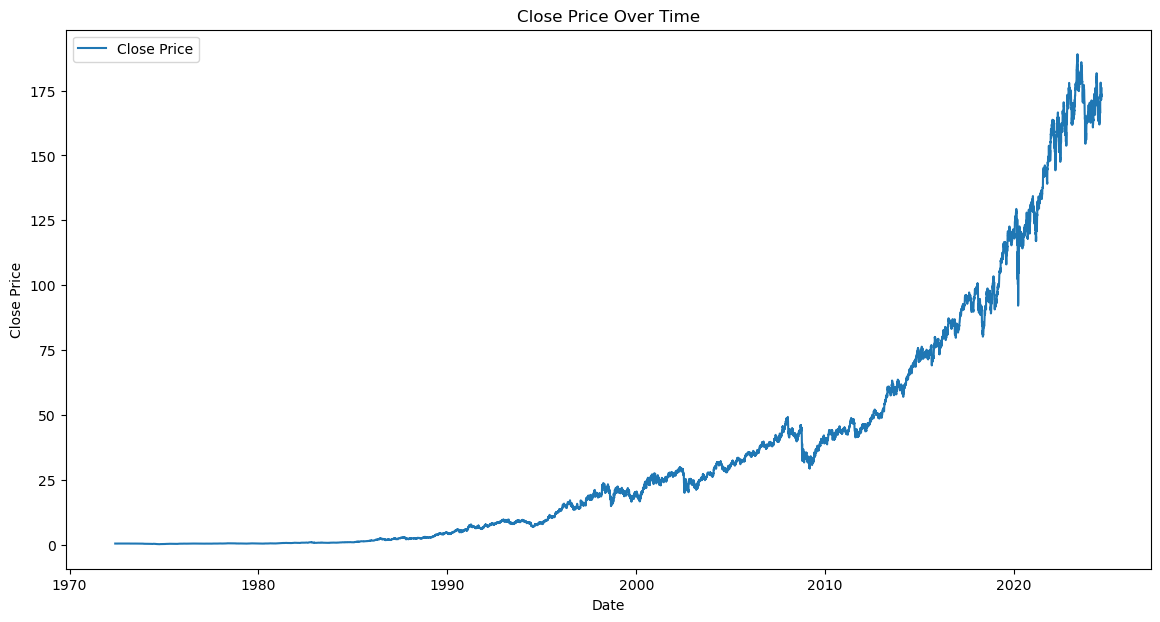

In [3]:
#all time close price change
plt.figure(figsize=(14,7))
plt.plot(pepsiData['Date'], pepsiData['Close'], label='Close Price')
plt.title('Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [4]:
# Feature engineering
pepsiData['Year'] = pepsiData['Date'].dt.year
pepsiData['Month'] = pepsiData['Date'].dt.month
pepsiData['Day'] = pepsiData['Date'].dt.day

In [5]:
# Adding extra features
pepsiData['MA100'] = pepsiData['Close'].rolling(window=100).mean()  # 100 day moving average
pepsiData['MA200'] = pepsiData['Close'].rolling(window=200).mean()  # 200 day moving average
pepsiData['Price_Change'] = pepsiData['Close'].diff()  # Price change
pepsiData['Volume_Change'] = pepsiData['Volume'].diff()  # Volume change

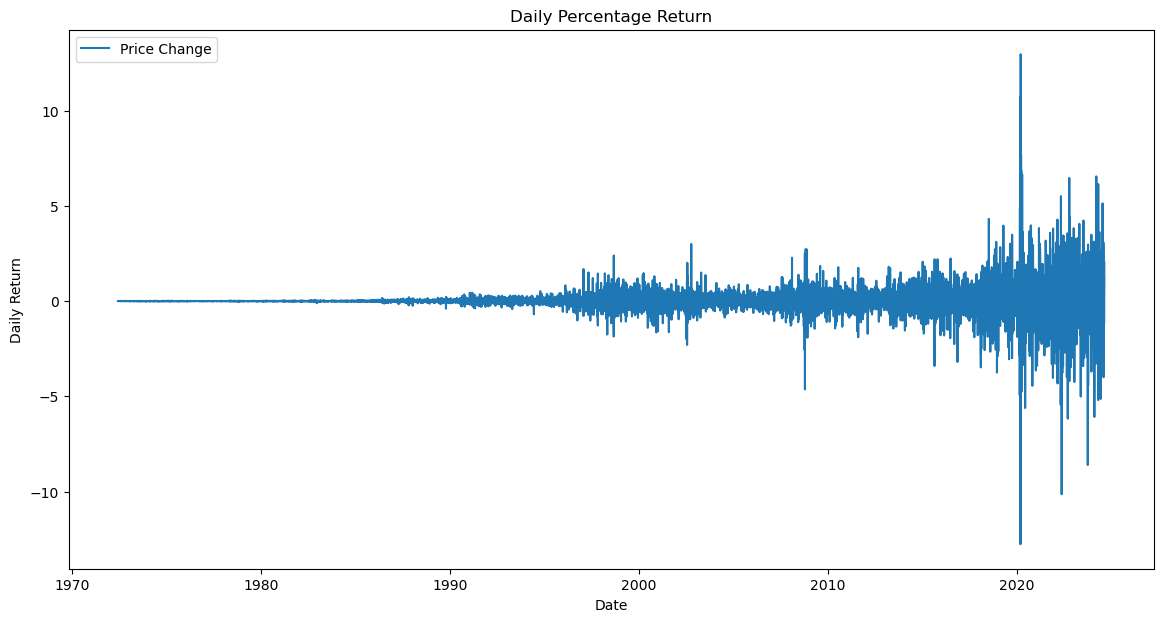

In [6]:
# Plot daily returns
plt.figure(figsize=(14, 7))
plt.plot(pepsiData['Date'], pepsiData['Price_Change'], label='Price Change')
plt.title('Daily Percentage Return')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.legend()
plt.show()

In [7]:
# Remove date column
pepsiData = pepsiData.drop("Date", axis=1)

In [8]:
pepsiData.head(5)

,Open,High,Low,Close,Volume,Year,Month,Day,MA100,MA200,Price_Change,Volume_Change
0,0.000000,0.399388,0.394770,0.399388,318600,1972,6,1,NaN,NaN,NaN,NaN
1,0.399388,0.403428,0.398233,0.398233,140400,1972,6,2,NaN,NaN,-0.001154,-178200.0
2,0.399391,0.399970,0.386078,0.393603,469800,1972,6,5,NaN,NaN,-0.004631,329400.0
3,0.390130,0.390130,0.388973,0.390130,140400,1972,6,6,NaN,NaN,-0.003473,-329400.0
4,0.390130,0.390709,0.386657,0.387815,178200,1972,6,7,NaN,NaN,-0.002315,37800.0


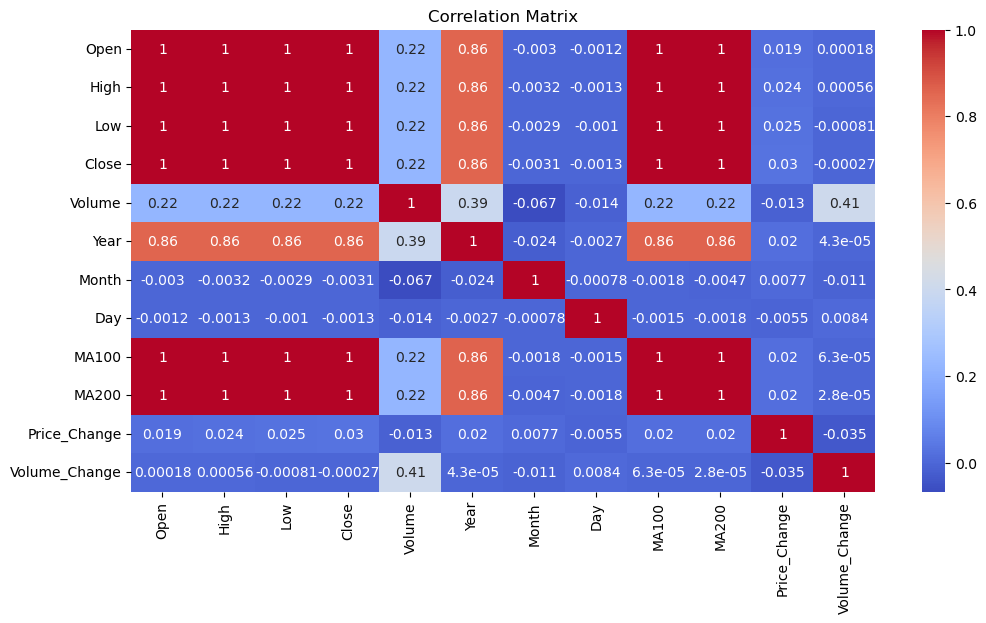

In [9]:
#correlation graph
corr_matrix = pepsiData.corr()

plt.figure(figsize=(12,6))
sbn.heatmap(corr_matrix, annot=True, cmap='coolwarm')

plt.title('Correlation Matrix')
plt.show()


In [10]:
pepsiData['MA100'] = pepsiData['MA100'].fillna(0) # 100 day moving average cleaning null data
pepsiData['MA200'] = pepsiData['MA200'].fillna(0) # 200 day moving average cleaning null data

In [11]:
# Checking for NaN values
print(pepsiData.isnull().sum())

# Padding NaN values ​​(with average)
pepsiData.fillna(pepsiData.mean(), inplace=True)

# Setting features and target variables
x = pepsiData[['Year', 'Month', 'Day', 'MA100', 'MA200', 'Price_Change', 'Volume_Change']].values  # Additional features
y = pepsiData[['Open', 'High', 'Low', 'Close', 'Volume']].values  # Values ​​to be estimated

# Splitting the data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=10)

# Scaling data
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

x_train = scaler_x.fit_transform(x_train)
x_test = scaler_x.transform(x_test)

# Hiperparametre aralığı
param_dist = {
    'n_estimators': [100, 200, 300, 500, 750, 1000],  # Ağaç sayısı
    'max_depth': [10, 15, 20, 25, 30, None],        # Maksimum derinlik
    'min_samples_split': [2, 10, 15, 20, 25, 30],   # Düğüm bölme için minimum örnek sayısı
    'min_samples_leaf': [1, 5],         # Yaprak düğümü için minimum örnek sayısı
    'max_features': ['sqrt', 'log2']  # Özelliklerin alt kümesi için seçim
}

# RandomForest modeli
rf = RandomForestRegressor(random_state=15)

# RandomizedSearchCV'yi oluşturun
random_search = RandomizedSearchCV(
    estimator=rf,            # Kullanılacak model
    param_distributions=param_dist,  # Hiperparametre aralıkları
    n_iter=100,              # Rastgele 100 farklı kombinasyon dene
    cv=5,                    # 5 katlı çapraz doğrulama
    verbose=2,               # Detaylı çıktı
    random_state=15,         # Rastgele sabitleme
    n_jobs=-1                # Tüm CPU çekirdeklerini kullanarak çalıştır
)

# Modeli RandomizedSearchCV ile eğitin
random_search.fit(x_train, y_train)

# En iyi hiperparametreleri kontrol et
print("En iyi hiperparametreler: ", random_search.best_params_)

# En iyi skoru kontrol et
print("En iyi R² skoru: ", random_search.best_score_)

# En iyi model ile tahmin
best_rf_model = random_search.best_estimator_

# Test seti tahminleri
y_pred = best_rf_model.predict(x_test)

# Performans metriklerini hesapla
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R² Score:", r2)

Open             0
High             0
Low              0
Close            0
Volume           0
Year             0
Month            0
Day              0
MA100            0
MA200            0
Price_Change     1
Volume_Change    1
dtype: int64
Fitting 5 folds for each of 100 candidates, totalling 500 fits
En iyi hiperparametreler:  {'n_estimators': 750, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 25}
En iyi R² skoru:  0.9505722722372442
Mean Squared Error (MSE): 303813879289.4307
Mean Absolute Error (MAE): 159895.8676302513
R² Score: 0.9562179430671003


Mean Squared Error (MSE): 303813879289.4307
Root Mean Squared Error (RMSE): 551193.1415478885
Mean Absolute Error (MAE): 159895.8676302513
R² Score: 0.9562179430671003


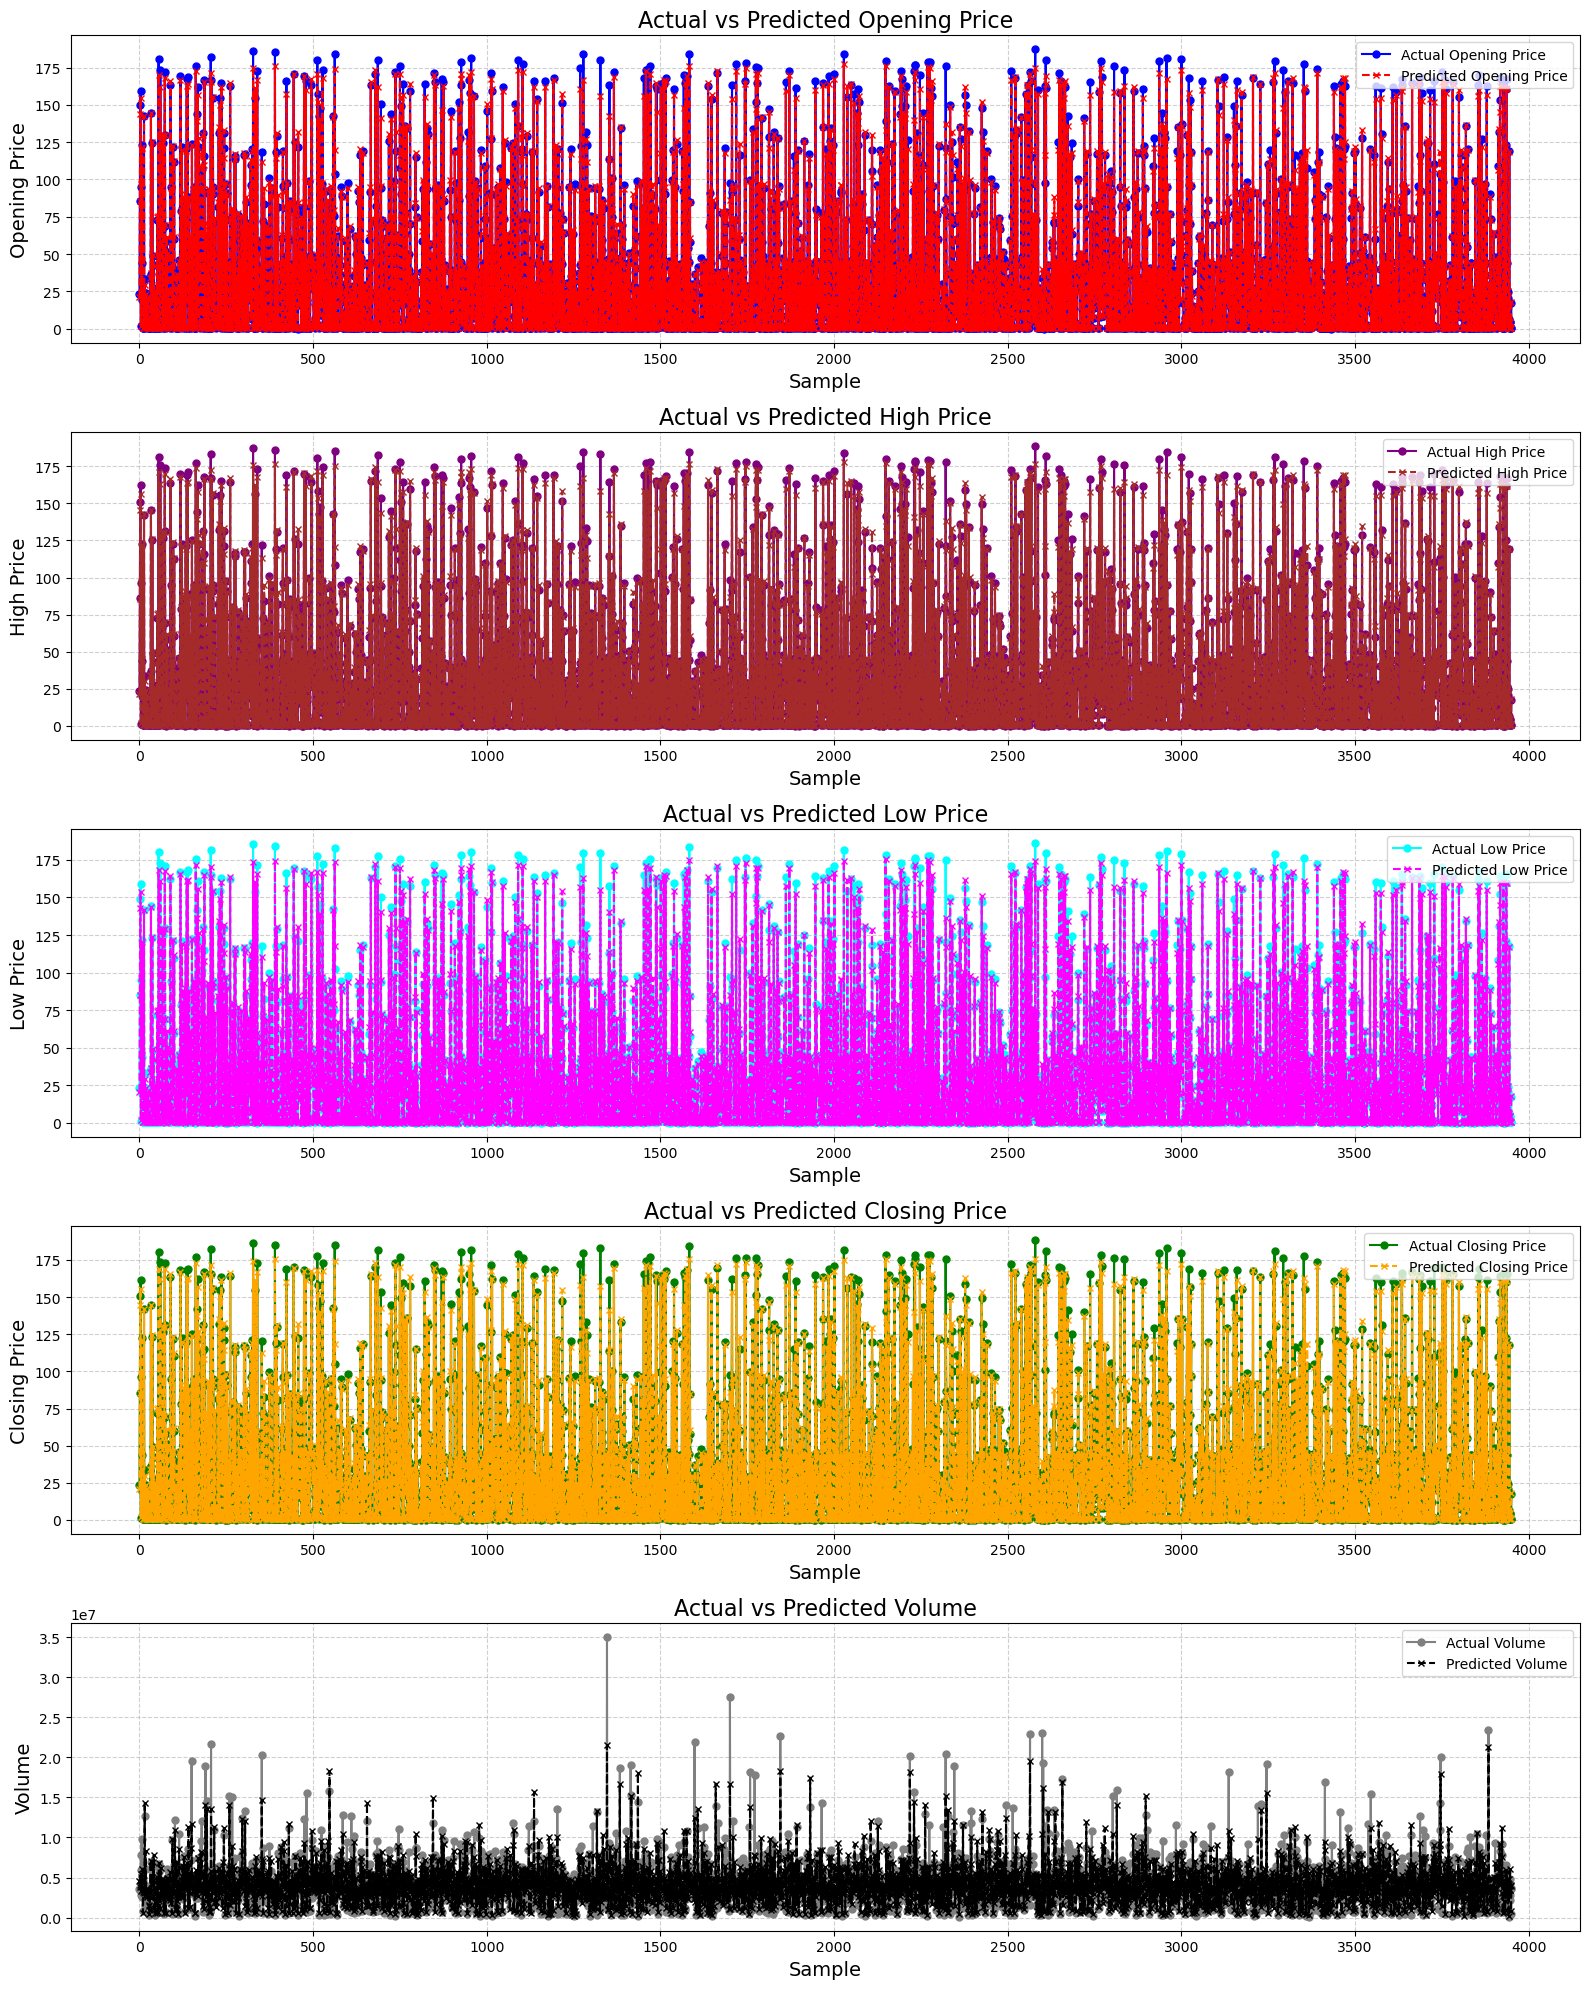

In [14]:
# Print results
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("R² Score:", r2)

# Creating subplots for each feature
plt.figure(figsize=(16, 20))

# Plot 1: Opening Price
plt.subplot(5, 1, 1)
plt.plot(y_test[:, 0], label='Actual Opening Price', color='blue', linestyle='-', marker='o', markersize=5)
plt.plot(y_pred[:, 0], label='Predicted Opening Price', color='red', linestyle='--', marker='x', markersize=5)
plt.title('Actual vs Predicted Opening Price', fontsize=16)
plt.xlabel('Sample', fontsize=14)
plt.ylabel('Opening Price', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Plot 2: High Price
plt.subplot(5, 1, 2)
plt.plot(y_test[:, 1], label='Actual High Price', color='purple', linestyle='-', marker='o', markersize=5)
plt.plot(y_pred[:, 1], label='Predicted High Price', color='brown', linestyle='--', marker='x', markersize=5)
plt.title('Actual vs Predicted High Price', fontsize=16)
plt.xlabel('Sample', fontsize=14)
plt.ylabel('High Price', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Plot 3: Low Price
plt.subplot(5, 1, 3)
plt.plot(y_test[:, 2], label='Actual Low Price', color='cyan', linestyle='-', marker='o', markersize=5)
plt.plot(y_pred[:, 2], label='Predicted Low Price', color='magenta', linestyle='--', marker='x', markersize=5)
plt.title('Actual vs Predicted Low Price', fontsize=16)
plt.xlabel('Sample', fontsize=14)
plt.ylabel('Low Price', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Plot 4: Closing Price
plt.subplot(5, 1, 4)
plt.plot(y_test[:, 3], label='Actual Closing Price', color='green', linestyle='-', marker='o', markersize=5)
plt.plot(y_pred[:, 3], label='Predicted Closing Price', color='orange', linestyle='--', marker='x', markersize=5)
plt.title('Actual vs Predicted Closing Price', fontsize=16)
plt.xlabel('Sample', fontsize=14)
plt.ylabel('Closing Price', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Plot 5: Volume
plt.subplot(5, 1, 5)
plt.plot(y_test[:, 4], label='Actual Volume', color='gray', linestyle='-', marker='o', markersize=5)
plt.plot(y_pred[:, 4], label='Predicted Volume', color='black', linestyle='--', marker='x', markersize=5)
plt.title('Actual vs Predicted Volume', fontsize=16)
plt.xlabel('Sample', fontsize=14)
plt.ylabel('Volume', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()
